# Bellman Equation
$$v_\pi(s)=\sum_{a} \pi(a|s) \sum_{s'} \sum_{r} p(s',r|s,a)(r+\gamma v_\pi(s'))$$
|term|meaning|
|----|---|
|$v_\pi(s)$|Value of state s under policy $\pi$|
|$\pi(a\|s)$|The current policy, what is the probability of taking action a at state s|
|$p(s',r\|s,a)$|The probability of arriving state s' and get reward r by taking action a at state s|
|$\gamma$|Discount factor, how much does future values influence current state|
|$v_\pi(s')$|The value of the arriving state|

后补充：这个公式是这个意思：<p>
在state s，你可以采取好多不同的action，action的选择遵循$\pi(a|s)$定义的概率<p>
而你选定了某一个action，这个选择又会带来不同的后果，你可以去到不同的新state s'并收到不同的reward r，这个后果事件的发生遵循$p(s',r|s,a)$定义的概率<p>
这个公式就是考虑所有可能的action，并对于每个action考虑所有可能的后果，这样把所有的可能性与可能的收益全都合一起算了一个期待值。<p>
这个期待值就是当前state s的价值state-value。<p>
例:小明当前state是高三，小明可以采取的action有好好学习和摆烂，小明有一定概率好好学习，一定概率摆烂，这是$\pi(a|s)$，然后小明如果好好学习，可能的后果有：{去大学A获得收益10，去大学A获得收益8，去大学B获得收益9，去大学B获得收益8，去大学B获得收益7，去大学C获得收益8，直接工作获得收益9 ...}，后果发生的概率为$p(s',r|s,a)$，毕业后去干什么是s'，获得收益是r。如果小明高三摆烂，那么也有可能有不同后果：{去大学B获得收益7，去大学D获得收益5，直接工作获得收益10，直接工作获得收益6，直接工作获得收益4，去大学E获得收益3，...}。小明当前状态的好坏要考虑其采取每个action的概率和采取每个action的期待收益，而采取每个action的期待收益就是采取这个action后的所有可能后果乘这些后果发生的可能性。

In [46]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

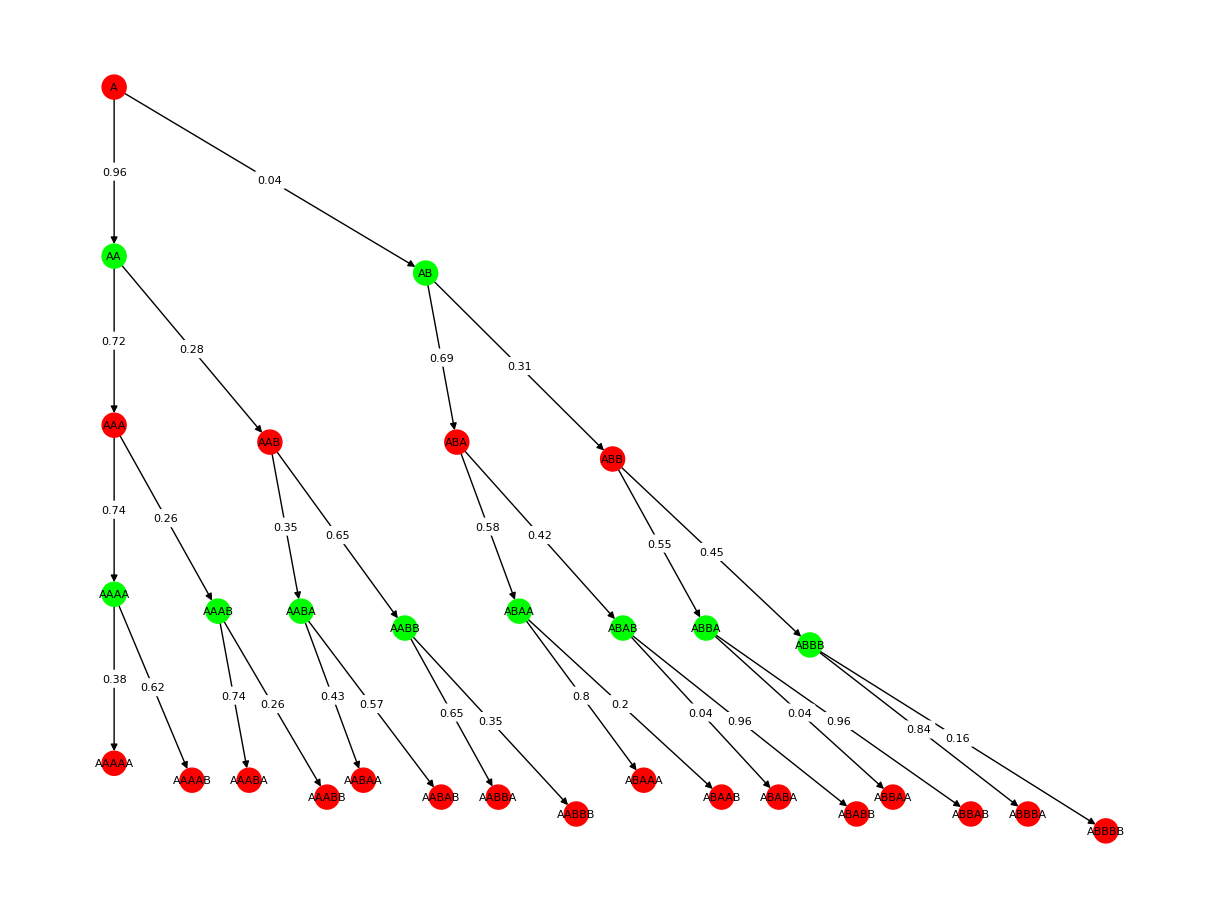

In [99]:
class TreeNode():
    alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    def __init__(self, name: str, is_state: bool) -> None:
        self.is_state = is_state
        self.is_action = not is_state
        self.name = name
        self.children = []
        self.weights = None
        self.rewards = np.random.rand(3)

    def generateChildren(self, num: int) -> None:
        weights = np.random.rand(num)
        self.weights = weights / np.sum(weights)
        for i in range(num):
            self.children.append(TreeNode(f"{self.name}{self.alphabet[i]}", not self.is_state))

    def generateChildrenForLeaf(self, num: int) -> None:
        if self.isLeaf():
            self.generateChildren(num)
        else:
            for node in self.children:
                node.generateChildrenForLeaf(num)

    def __len__(self):
        return len(self.children)

    def isLeaf(self):
        return len(self.children) == 0


class Tree():
    def __init__(self) -> None:
        self.root = TreeNode("A", True)

    def getGraph(self):
        graph = nx.DiGraph()

        nodes = []
        edges = []
        colors = []
        pos = {"A": np.zeros(2)}
        queue = [self.root]
        depth = 0
        while len(queue) != 0:
            depth += 1
            temp_queue = []
            for ni, node in enumerate(queue):
                nodes.append(node.name)
                colors.append("#ff0000" if node.is_state else "#00ff00")
                temp_queue.extend(node.children)
                for i in range(len(node)):
                    pos[node.children[i].name] = pos[node.name] + np.array([i/depth+0.1*ni, -1.0-i*0.1])
                    edges.append((node.name, node.children[i].name, node.weights[i]))
            queue = temp_queue

        plt.figure(figsize=(12, 9))
        graph.add_nodes_from(nodes)
        graph.add_weighted_edges_from(edges)
        nx.draw(graph, pos, with_labels=True, font_size=8, node_color=colors)
        labels = {k:np.round(v, decimals=2) for k, v in nx.get_edge_attributes(graph, 'weight').items()}
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, rotate=False, label_pos=0.5, font_size=8)
        return graph

tree = Tree()
tree.root.generateChildrenForLeaf(2)
tree.root.generateChildrenForLeaf(2)
tree.root.generateChildrenForLeaf(2)
tree.root.generateChildrenForLeaf(2)
tree.getGraph()
plt.show()


- Red nodes: state
- Green nodes: action

In [101]:
def value_of(state: TreeNode, gamma=1.0) -> float:
    if state.isLeaf():
        return np.mean(state.rewards)
    
    value = 0
    for ai, action in enumerate(state.children):
        policy_ai = state.weights[ai]    # probability of choosing action a at this state
        action_value = 0
        for sj, next_state in enumerate(action.children):   # ----------------------- This part computes the value gain after the action ai is taken,
            for r in next_state.rewards:                                     #    --- p is the probability of arriving state sj and get reward r,
                p = action.weights[sj] * 1/3                                 #    --- we assume there are 3 possible rewards, each with probability 1/3
                action_value += p * (r + gamma * value_of(next_state, gamma))  # ----
        value += policy_ai * action_value
    return value
                

print(value_of(tree.root.children[0].children[0]))


1.0603927184064188


In [106]:
print(tree.root.children[0].children[0].children[0].rewards)
print(tree.root.children[0].children[0].children[1].rewards)
print()
print(tree.root.children[0].children[0].children[0].children[0].rewards.mean())
print(tree.root.children[0].children[0].children[0].children[1].rewards.mean())
print()
print(tree.root.children[0].children[0].children[1].children[0].rewards.mean())
print(tree.root.children[0].children[0].children[1].children[1].rewards.mean())

[0.7930574  0.42249783 0.00380931]
[0.04488346 0.89479329 0.50303733]

0.3493917738311915
0.7714639294605491

0.5363931281500026
0.48493959307018525


In [ ]:
0.3493917738311915*0.38+0.7714639294605491*0.62